## Automatic Differentiation

This is a simple implementation of automatic differentiation in Python. It is based on the chain rule and supports both scalar and vector functions. The code is well-documented and easy to understand. We will use this implementation to derive the gradient of a scalar function $\psi(x,y)$ with respect to $x$ and $y$ in schrodinger equation to get the best potential curve for a given Hamiltonian.

In [77]:
import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jacrev
import matplotlib.pyplot as plt
import jax.scipy as jsp
from jax.scipy.special import logsumexp
from scipy import special
import numpy as np
from sklearn import preprocessing  

In [78]:
!nvidia-smi
jax.devices()

Tue Jul  8 16:48:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.81                 Driver Version: 560.81         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   55C    P8              3W /  110W |    2166MiB /   8188MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[CpuDevice(id=0)]

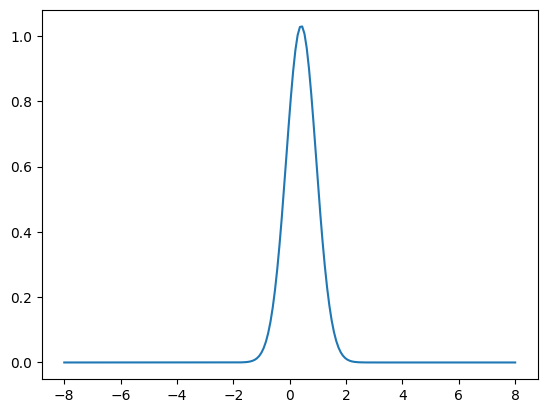

In [79]:
x0 = np.random.uniform(-3, 3)  # 随机中心位置
sigma = np.random.uniform(0.5, 2)  # 随机宽度

# 定义高斯波包
def wave_function(x, x0, sigma):
    norm = (1/(np.sqrt(np.pi)*sigma))**0.5
    return norm * np.exp(-(x-x0)**2/(2*sigma**2))
num = 200  # 网格点数
x_max = 8.0  # x的最大值
x = np.linspace(-x_max, x_max, num)  # x的取值范围
dx = x[1] - x[0]  # 网格间距

real_wave_function = wave_function(x, x0, sigma)
plt.plot(x, real_wave_function)
plt.show()


## Automatic Differentiation For Potential Curve Fitting
Here we will implement automatic differentiation to fit a potential curve to theoritical data.

Final energy: [-1.7216557e+02 -1.4851468e+02 -1.3024268e+02 -1.1490733e+02
 -1.0155595e+02 -8.9689560e+01 -7.9005196e+01 -6.9302010e+01
 -6.0438583e+01 -5.2311466e+01 -4.4843021e+01 -3.7974152e+01
 -3.1659962e+01 -2.5867086e+01 -2.0572393e+01 -1.5762567e+01
 -1.1435545e+01 -7.6039195e+00 -4.3047147e+00 -1.6299436e+00
  1.5015341e-01  1.0929022e+00  2.2384021e+00  3.5179994e+00
  4.9042816e+00  6.3767042e+00  7.9232655e+00  9.5351315e+00
  1.1205601e+01  1.2929286e+01  1.4701719e+01  1.6519182e+01
  1.8378393e+01  2.0276548e+01  2.2211100e+01  2.4179794e+01
  2.6180569e+01  2.8211550e+01  3.0271000e+01  3.2357311e+01
  3.4468990e+01  3.6604614e+01  3.8762863e+01  4.0942471e+01
  4.3142250e+01  4.5361053e+01  4.7597778e+01  4.9851368e+01
  5.2120831e+01  5.4405155e+01  5.6703396e+01  5.9014618e+01
  6.1337929e+01  6.3672421e+01  6.6017242e+01  6.8371521e+01
  7.0734413e+01  7.3105095e+01  7.5482727e+01  7.7866486e+01
  8.0255562e+01  8.2649170e+01  8.5046455e+01  8.7446648e+01
  8.984894

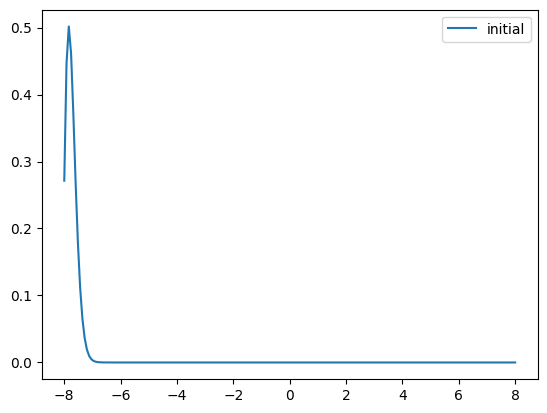

In [80]:

from jax.scipy.linalg import eigh

def v_d(a, b, c, d, x):
    """
    初始化势能
    :param x: 粒子的位置，数组
    :return: 势能值，标量
    """
    return a*x+b*x**2+c*x**3+d


def Hamiltonian(a, b, c, d, x, num):
    H = jnp.zeros((num, num))
    v = v_d(a, b, c, d, x)  # 势能数组
    K = jnp.zeros((num, num))
    
    # 构造动能矩阵
    for i in range(num):
        for j in range(num):
            if i == j:
                K = K.at[i, j].set(-2)
            elif i == j + 1 or i == j - 1:
                K = K.at[i, j].set(1)
            else:
                K = K.at[i, j].set(0)
    
    # 构造哈密顿量
    for i in range(num):
        for j in range(num):
            H = H.at[i, j].set(-0.5 *( 1 / dx)**2 * K[i, j] + v[i] * (i == j))
    
    return H
a, b, c, d = 1.0, 1.0, 0.5, 0.5
energy, initial = jax.scipy.linalg.eigh(Hamiltonian(a, b, c, d, x, num=num))
print(f"Final energy: {energy}")
plt.plot(x, initial[:,0], label="initial")

plt.legend()
plt.show()

In [82]:

def loss(a, b, c, d):
    H = Hamiltonian(a, b, c, d, x, num)
    _, eigenstate = jax.scipy.linalg.eigh(H)
    real1 = real_wave_function
    cal = jnp.abs(eigenstate[ :,0])
    loss =jnp.abs(real1)**2 - jnp.abs(cal)**2
    return jnp.sum(loss)

def train(a, b, c, d, num_epochs=100, learning_rate=0.1):
    for epoch in range(num_epochs):
        # 计算损失和梯度
        loss_value, grads = jax.value_and_grad(loss, argnums=(0, 1, 2, 3))(a, b, c, d)

        # 更新参数
        a -= learning_rate * grads[0]
        b -= learning_rate * grads[1]
        c -= learning_rate * grads[2]
        d -= learning_rate * grads[3]

        # 每 100 个 epoch 打印一次损失值
        print(f"Epoch {epoch}, loss = {loss_value}, grads = {grads}")
     
            
    return a, b, c, d
a, b, c, d = 1.0, 1.0, 0.5, 0.5
a, b, c, d = train(a, b, c, d)
print(f"Final parameters: a={a}, b={b}, c={c}, d={d}")


energy, cal = jax.scipy.linalg.eigh(Hamiltonian(a, b, c, d, x, num=num))

plt.plot(x, real_wave_function, label="real")
plt.plot(x, cal[:,0], label="cal")
plt.legend()
plt.show()



Epoch 0, loss = 11.4375, grads = (Array(-1.2117133e-09, dtype=float32, weak_type=True), Array(1.8672285e-08, dtype=float32, weak_type=True), Array(-2.1585764e-07, dtype=float32, weak_type=True), Array(4.230995e-15, dtype=float32, weak_type=True))


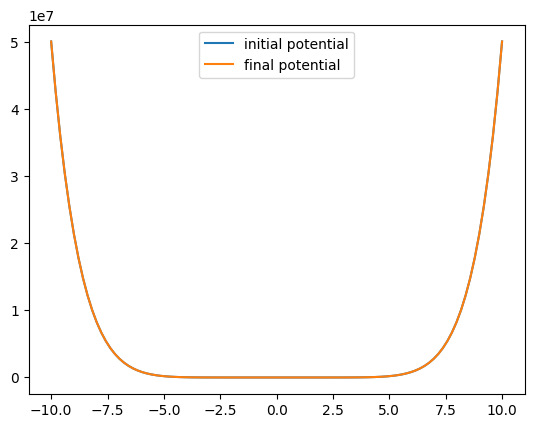

In [ ]:
plt.plot(x, v_d(10, 10, 0.5, 0.5, x), label="initial potential")
plt.plot(x, v_d(a, b, c, d, x), label="final potential")
plt.legend()
plt.show()